In [1]:
import _base_path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.data_io import load_mappings
from resources.metrics import ConfusionMatrix

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from typing import Union, Iterable

Setting base bath to "c:\Users\Korbi\Documents\Uni\PhD\23-10_ConformalPrompting\code"


In [2]:
DATA      = 'incidents'
LABEL     = 'product_category'
MODEL     = 'palm'
SHOTS     = 2
CV_SPLITS = [0]#, 1, 2, 3, 4]

# Load Class-Mappings:

In [3]:
class_map = load_mappings(f'../data/{DATA}/splits/', LABEL)
class_map

array(['alcoholic beverages', 'bivalve molluscs and products therefor',
       'cephalopods and products thereof', 'cereals and bakery products',
       'cocoa and cocoa preparations, coffee and tea', 'confectionery',
       'crustaceans and products thereof',
       'dietetic foods, food supplements, fortified foods',
       'eggs and egg products', 'fats and oils', 'feed additives',
       'feed materials', 'fish and fish products',
       'food additives and flavourings', 'food contact materials',
       'fruits and vegetables', 'herbs and spices',
       'honey and royal jelly', 'ices and desserts',
       'meat and meat products (other than poultry)',
       'milk and milk products', 'non-alcoholic beverages',
       'nuts, nut products and seeds', 'other food product / mixed',
       'pet feed', 'poultry meat and poultry meat products',
       'prepared dishes and snacks',
       'soups, broths, sauces and condiments', 'sugars and syrups'],
      dtype='<U49')

In [4]:
with open('../data/incidents/support_zones.json', 'r') as file:
    high_support, low_support = json.load(file)[LABEL]

In [5]:
high_support

['meat and meat products (other than poultry)',
 'cereals and bakery products',
 'fruits and vegetables']

In [6]:
low_support

['cocoa and cocoa preparations, coffee and tea',
 'ices and desserts',
 'fish and fish products',
 'confectionery',
 'herbs and spices',
 'dietetic foods, food supplements, fortified foods',
 'non-alcoholic beverages',
 'alcoholic beverages',
 'other food product / mixed',
 'eggs and egg products',
 'crustaceans and products thereof',
 'bivalve molluscs and products therefor',
 'fats and oils',
 'food contact materials',
 'pet feed',
 'food additives and flavourings',
 'honey and royal jelly',
 'feed materials',
 'sugars and syrups',
 'cephalopods and products thereof',
 'feed additives']

In [7]:
counts = pd.read_csv('../data/incidents/incidents_final.csv')[LABEL].value_counts()

class_map = list(zip(
    class_map,
    range(len(class_map)),
    [counts[c] if c in counts else 0 for c in class_map]
))
class_map.sort(key=lambda row:row[2], reverse=True)
class_map

[('meat and meat products (other than poultry)', 19, 1040),
 ('cereals and bakery products', 3, 974),
 ('fruits and vegetables', 15, 811),
 ('prepared dishes and snacks', 26, 668),
 ('milk and milk products', 20, 551),
 ('poultry meat and poultry meat products', 25, 471),
 ('nuts, nut products and seeds', 22, 408),
 ('soups, broths, sauces and condiments', 27, 390),
 ('ices and desserts', 18, 305),
 ('cocoa and cocoa preparations, coffee and tea', 4, 303),
 ('fish and fish products', 12, 283),
 ('confectionery', 5, 254),
 ('herbs and spices', 16, 216),
 ('dietetic foods, food supplements, fortified foods', 7, 214),
 ('non-alcoholic beverages', 21, 208),
 ('alcoholic beverages', 0, 99),
 ('other food product / mixed', 23, 86),
 ('eggs and egg products', 8, 67),
 ('crustaceans and products thereof', 6, 56),
 ('bivalve molluscs and products therefor', 1, 39),
 ('fats and oils', 9, 32),
 ('food contact materials', 14, 26),
 ('pet feed', 24, 23),
 ('food additives and flavourings', 13, 15),

# Load Results:

In [8]:
results = pd.read_csv(f'../results/{MODEL}/{MODEL}_{LABEL}_{SHOTS:d}-shot.csv').fillna('')
results['label'] = [l for l in results['label']]

results = results[['cv_split', 'label'] + [col for col in results.columns if col.startswith('output_')]]

results.head()

,cv_split,label,output_limited,output_conformal_5%,output_max-5,output_max-10
0,0,meat and meat products (other than poultry),meat and meat products,meat and meat products (other than poultry),meat and meat products (other than poultry),meat and meat products (other than poultry)
1,0,meat and meat products (other than poultry),meat and meat products (other than poultry),meat and meat products (other than poultry),meat and meat products (other than poultry),meat and meat products (other than poultry)
2,0,fish and fish products,fish and fish products,fish and fish products,fish and fish products,fish and fish products
3,0,meat and meat products (other than poultry) | ...,meat and meat products,poultry meat and poultry meat products,poultry meat and poultry meat products,poultry meat and poultry meat products
4,0,poultry meat and poultry meat products,prepared dishes and snacks,prepared dishes and snacks,prepared dishes and snacks,prepared dishes and snacks


In [9]:
def calculate_metrics(classes=[c.lower() for c, _, _ in class_map], filter_empty=False):
    metrics = {}

    for col in results.drop(columns=['cv_split', 'label']).columns:
        f1        = []
        recall    = []
        precision = []
        accuracy  = []

        for i in CV_SPLITS:
            r = results[results['cv_split'] == i][['label', col]].values
            
            if (r[:,1] == '').all():
                print(f'Skipping split {i:d} of column "{col}"')
                continue
            
            if filter_empty:
                r = r[r[:,1] != '']

            y_true, y_pred = [], []
            for labels, prediction in r:
                y_true.append([c in labels for c in classes])
                y_pred.append([c.lower() == prediction.lower() for c in classes])
                #y_pred.append([all([t in prediction.lower() for t in c.split()]) or all([t.lower() in c for t in prediction.split()]) for c in classes])
            y_true = np.array(y_true, dtype=float)
            y_pred = np.array(y_pred, dtype=float)

            f1.append(f1_score(y_true, y_pred, average='macro'))
            recall.append(recall_score(y_true, y_pred, average='macro'))
            precision.append(precision_score(y_true, y_pred, average='macro'))
            accuracy.append(accuracy_score(y_true, y_pred))

        metrics[col] = {
            'f1':        (np.mean(f1), np.std(f1)),
            'recall':    (np.mean(recall), np.std(recall)),
            'precision': (np.mean(precision), np.std(precision)),
            'accuracy':  (np.mean(accuracy), np.std(accuracy))
        }
    return metrics

In [10]:
metrics_all = calculate_metrics(filter_empty=True)
metrics_high_support = calculate_metrics(high_support, filter_empty=True)
metrics_low_support = calculate_metrics(low_support, filter_empty=True)

C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Korbi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: Undefine

In [11]:
def print_table(metrics:Iterable[str] = ['f1', 'accuracy']):
    for model in metrics_all:
        row =  f'{model.upper()} &\n'

        if model in metrics_all:
            row += ' & '.join([f'${metrics_all[model][metric][0]:.2f} \pm {metrics_all[model][metric][1]:.2f}$' for metric in metrics])
        else:
            row += ' &'*(len(metrics)-1)
            
        row += ' &\n'

        if model in metrics_high_support:
            row += ' & '.join([f'${metrics_high_support[model][metric][0]:.2f} \pm {metrics_high_support[model][metric][1]:.2f}$' for metric in metrics])
        else:
            row += ' &'*(len(metrics)-1)

        row += ' &\n'

        if model in metrics_high_support:
            row += ' & '.join([f'${metrics_low_support[model][metric][0]:.2f} \pm {metrics_low_support[model][metric][1]:.2f}$' for metric in metrics])
        else:
            row += ' &'*(len(metrics)-1)
        row += ' \\\\\n'
        print(row)

In [12]:
print_table()

OUTPUT_LIMITED &
$0.48 \pm 0.00$ & $0.43 \pm 0.00$ &
$0.50 \pm 0.00$ & $0.71 \pm 0.00$ &
$0.46 \pm 0.00$ & $0.75 \pm 0.00$ \\

OUTPUT_CONFORMAL_5% &
$0.57 \pm 0.00$ & $0.66 \pm 0.00$ &
$0.73 \pm 0.00$ & $0.82 \pm 0.00$ &
$0.52 \pm 0.00$ & $0.80 \pm 0.00$ \\

OUTPUT_MAX-5 &
$0.56 \pm 0.00$ & $0.66 \pm 0.00$ &
$0.74 \pm 0.00$ & $0.83 \pm 0.00$ &
$0.50 \pm 0.00$ & $0.83 \pm 0.00$ \\

OUTPUT_MAX-10 &
$0.55 \pm 0.00$ & $0.65 \pm 0.00$ &
$0.73 \pm 0.00$ & $0.82 \pm 0.00$ &
$0.50 \pm 0.00$ & $0.81 \pm 0.00$ \\



# Failure analysis:

In [13]:
label_types = set(results.label.values)
label_types

{'alcoholic beverages',
 'bivalve molluscs and products therefor',
 'cephalopods and products thereof',
 'cereals and bakery products',
 'cereals and bakery products | cocoa and cocoa preparations, coffee and tea | confectionery',
 'cereals and bakery products | cocoa and cocoa preparations, coffee and tea | nuts, nut products and seeds',
 'cereals and bakery products | confectionery',
 'cereals and bakery products | dietetic foods, food supplements, fortified foods',
 'cereals and bakery products | non-alcoholic beverages',
 'cereals and bakery products | other food product / mixed',
 'cereals and bakery products | prepared dishes and snacks',
 'cereals and bakery products | soups, broths, sauces and condiments',
 'cocoa and cocoa preparations, coffee and tea',
 'cocoa and cocoa preparations, coffee and tea | confectionery',
 'cocoa and cocoa preparations, coffee and tea | dietetic foods, food supplements, fortified foods',
 'cocoa and cocoa preparations, coffee and tea | non-alcoholi

In [14]:
for col in results.columns:
    f1 = [f1_score(
        results[results.cv_split == i].label.values,
        results[results.cv_split == i][col].apply(lambda p: p if p in label_types else 'fail'),
        average='macro'
    ) for i in CV_SPLITS]

    acc = [accuracy_score(
        results[results.cv_split == i].label.values,
        results[results.cv_split == i][col].apply(lambda p: p if p in label_types else 'fail')
    ) for i in CV_SPLITS]

    fail = [np.mean(
        results[results.cv_split == i][col].apply(lambda p: not (p in label_types))
    ) for i in CV_SPLITS]

    empty = [np.mean(
        results[results.cv_split == i][col].apply(lambda p: p == '')
    ) for i in CV_SPLITS]

    print(f'{col.upper()}:')
    print(f'  F1:       {np.mean(f1):.2f} \u00b1 {np.std(f1):.2f}')
    print(f'  Accuracy: {np.mean(acc):.2f} \u00b1 {np.std(acc):.2f}')
    print(f'  Failed:   {np.mean(fail):.2f} \u00b1 {np.std(fail):.2f}')
    print(f'  Empty:    {np.mean(empty):.2f} \u00b1 {np.std(empty):.2f}')
    print('\n')

CV_SPLIT:
  F1:       0.00 ± 0.00
  Accuracy: 0.00 ± 0.00
  Failed:   1.00 ± 0.00
  Empty:    0.00 ± 0.00


LABEL:
  F1:       1.00 ± 0.00
  Accuracy: 1.00 ± 0.00
  Failed:   0.00 ± 0.00
  Empty:    0.00 ± 0.00


OUTPUT_LIMITED:
  F1:       0.41 ± 0.00
  Accuracy: 0.44 ± 0.00
  Failed:   0.27 ± 0.00
  Empty:    0.00 ± 0.00


OUTPUT_CONFORMAL_5%:
  F1:       0.50 ± 0.00
  Accuracy: 0.68 ± 0.00
  Failed:   0.03 ± 0.00
  Empty:    0.00 ± 0.00


OUTPUT_MAX-5:
  F1:       0.49 ± 0.00
  Accuracy: 0.68 ± 0.00
  Failed:   0.07 ± 0.00
  Empty:    0.01 ± 0.00


OUTPUT_MAX-10:
  F1:       0.48 ± 0.00
  Accuracy: 0.66 ± 0.00
  Failed:   0.07 ± 0.00
  Empty:    0.02 ± 0.00




# Plot confusion matrix

In [15]:
r = results[results['cv_split'] == 0][['label', 'output_conformal_5%']].values
r = r[r[:,1] != '']

for i in [0,1]:
    hs_mask = np.array([s in high_support for s in r[:,i]])
    ls_mask = np.array([s in low_support for s in r[:,i]])
    ms_mask = ~(hs_mask | ls_mask)

    r[hs_mask, i] = 0
    r[ms_mask, i] = 1
    r[ls_mask, i] = 2

cm = ConfusionMatrix(r[:,0], r[:,1], classes=["High", "Medium", "Low"])

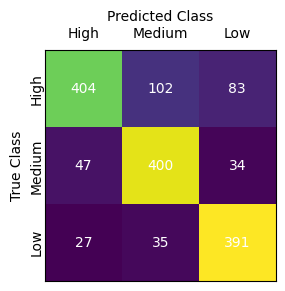

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
cm.plot(axs)
fig.savefig(f'../pictures/plots/cm_conformal_{LABEL}.pdf')